**IMPORT** **AND** **LOAD**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("household_power_consumption.txt", sep=';', low_memory=False)
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Global_active_power'] = df['Global_active_power'].astype(float)
df.set_index('DateTime', inplace=True)
print(df.head())


                           Date      Time  Global_active_power  \
DateTime                                                         
2006-12-16 17:24:00  16/12/2006  17:24:00                4.216   
2006-12-16 17:25:00  16/12/2006  17:25:00                5.360   
2006-12-16 17:26:00  16/12/2006  17:26:00                5.374   
2006-12-16 17:27:00  16/12/2006  17:27:00                5.388   
2006-12-16 17:28:00  16/12/2006  17:28:00                3.666   

                    Global_reactive_power  Voltage Global_intensity  \
DateTime                                                              
2006-12-16 17:24:00                 0.418  234.840           18.400   
2006-12-16 17:25:00                 0.436  233.630           23.000   
2006-12-16 17:26:00                 0.498  233.290           23.000   
2006-12-16 17:27:00                 0.502  233.740           23.000   
2006-12-16 17:28:00                 0.528  235.680           15.800   

                    Sub_metering_1 Sub_

**TASK** **1**  **EDA**

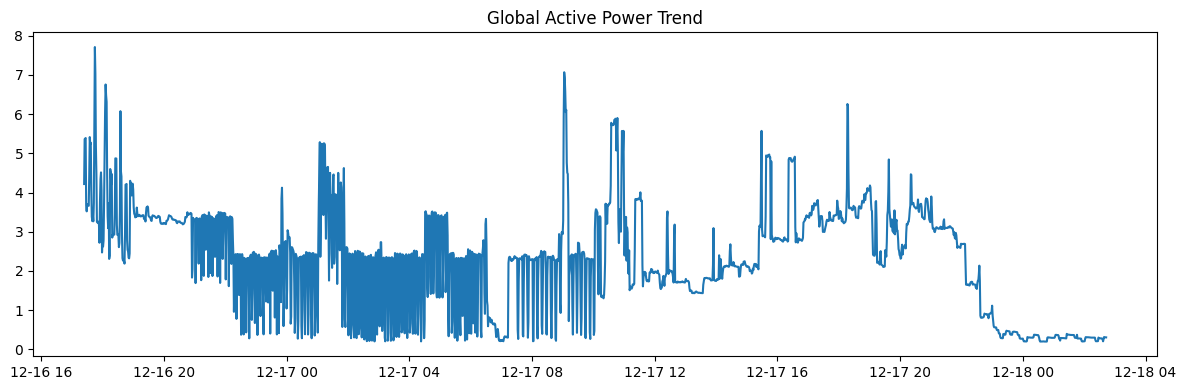

count    2.049280e+06
mean     1.091615e+00
std      1.057294e+00
min      7.600000e-02
25%      3.080000e-01
50%      6.020000e-01
75%      1.528000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64


In [14]:
plt.figure(figsize=(12,4))
plt.plot(df.index[:2000], df['Global_active_power'][:2000])
plt.title('Global Active Power Trend')
plt.tight_layout()
plt.show()


print(df['Global_active_power'].describe())


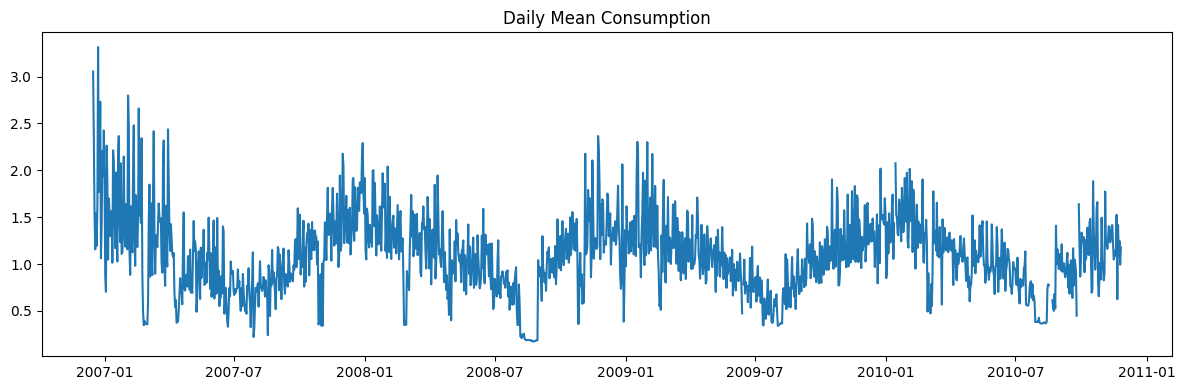

count    2.049280e+06
mean     1.091615e+00
std      1.057294e+00
min      7.600000e-02
25%      3.080000e-01
50%      6.020000e-01
75%      1.528000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64


In [15]:
daily_mean = df['Global_active_power'].resample('D').mean()
plt.figure(figsize=(12,4))
plt.plot(daily_mean)
plt.title('Daily Mean Consumption')
plt.tight_layout()
plt.show()
print(df['Global_active_power'].describe())

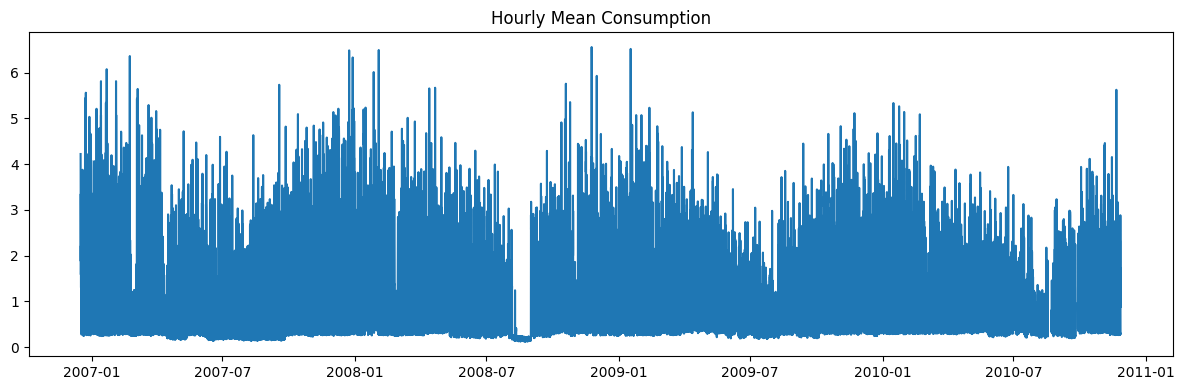

count    2.049280e+06
mean     1.091615e+00
std      1.057294e+00
min      7.600000e-02
25%      3.080000e-01
50%      6.020000e-01
75%      1.528000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64


In [16]:
hourly_mean = df['Global_active_power'].resample('H').mean()
plt.figure(figsize=(12,4))
plt.plot(hourly_mean)
plt.title('Hourly Mean Consumption')
plt.tight_layout()
plt.show()
print(df['Global_active_power'].describe())

**TASK** **2** **SUPERVISED** **LEARNING** (**MLP** **REGRESSOR**)

Model trained successfully ✔
MAE = 0.0785142594247571
RMSE = 0.21297245742218776


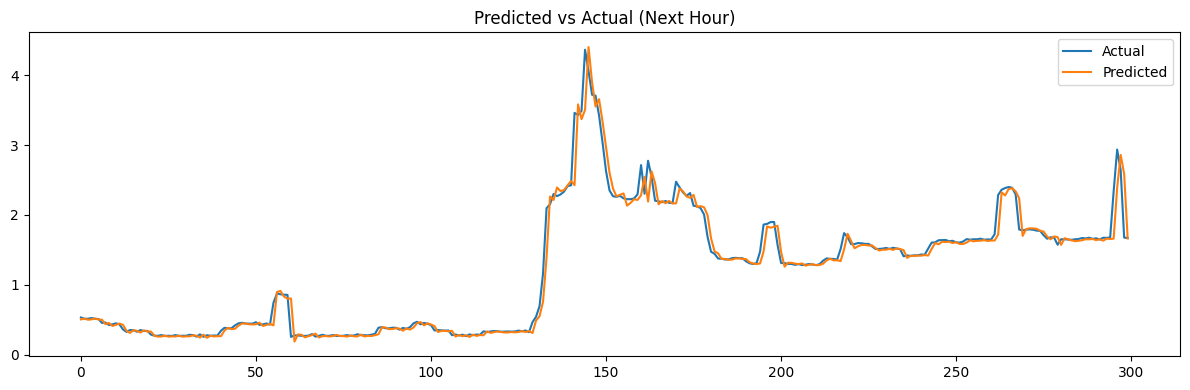

In [17]:
def make_windows(series, win=24):
    X, y = [], []
    for i in range(len(series)-win):
        X.append(series[i:i+win])
        y.append(series[i+win])
    return np.array(X), np.array(y)

values = df['Global_active_power'].values
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values.reshape(-1,1)).flatten()

X, y = make_windows(values_scaled, win=24)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = MLPRegressor(hidden_layer_sizes=(64,32), max_iter=300)
model.fit(X_train, y_train)
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
print("Model trained successfully ✔")


mae = mean_absolute_error(y_true, pred)
rmse = np.sqrt(mean_squared_error(y_true, pred))
print("MAE =", mae)
print("RMSE =", rmse)

plt.figure(figsize=(12,4))
plt.plot(y_true[:300], label='Actual')
plt.plot(pred[:300], label='Predicted')
plt.legend()
plt.title('Predicted vs Actual (Next Hour)')
plt.tight_layout()
plt.show()

**TASK** **3** **UNSUPERVISED** **LEARNING**

**ANOMALY** **DETECTION**

Anomalies detected: 22365


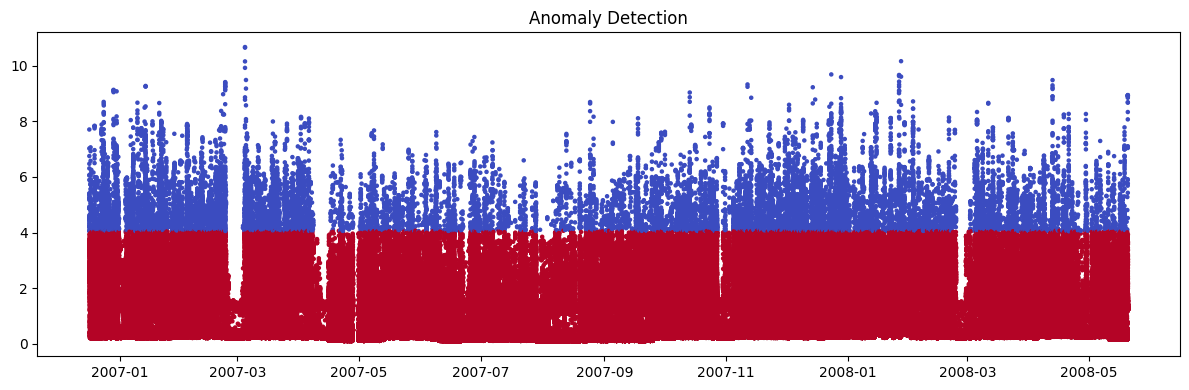

In [7]:
iso = IsolationForest(contamination=0.03, random_state=42)
df['Anomaly'] = iso.fit_predict(df[['Global_active_power']])
anomaly_count = (df['Anomaly'] == -1).sum()
print("Anomalies detected:", anomaly_count)

plt.figure(figsize=(12,4))
plt.scatter(df.index, df['Global_active_power'], s=5, c=df['Anomaly'], cmap='coolwarm')
plt.title("Anomaly Detection")
plt.tight_layout()
plt.show()


**CLUSTERING**

            Global_active_power  Cluster
DateTime                                
2006-12-16             3.053475        2
2006-12-17             2.354486        2
2006-12-18             1.530435        1
2006-12-19             1.157079        1
2006-12-20             1.545658        1


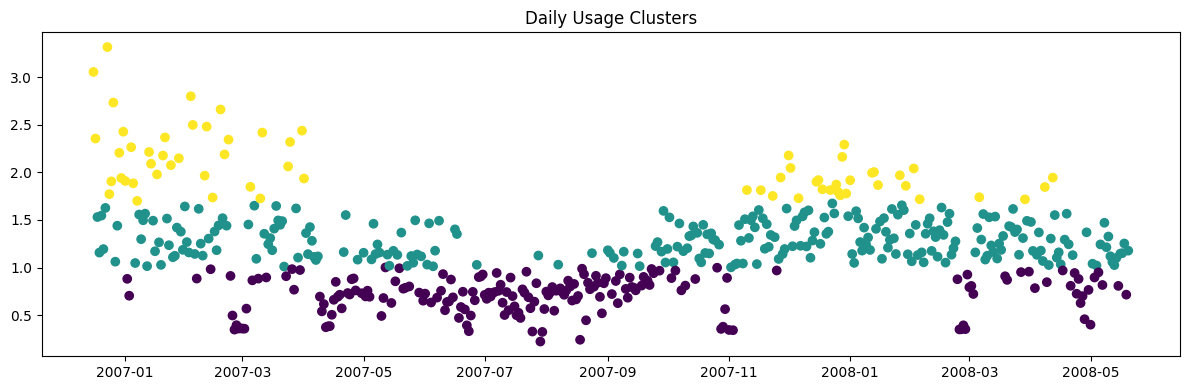

Cluster
0    0.714128
1    1.287545
2    2.076531
Name: Global_active_power, dtype: float64


In [9]:
daily = df['Global_active_power'].resample('D').mean().to_frame()
daily.dropna(inplace=True) # Added to handle NaN values before KMeans
km = KMeans(n_clusters=3, random_state=42)
daily['Cluster'] = km.fit_predict(daily[['Global_active_power']])
print(daily.head())

plt.figure(figsize=(12,4))
plt.scatter(daily.index, daily['Global_active_power'], c=daily['Cluster'], cmap='viridis')
plt.title("Daily Usage Clusters")
plt.tight_layout()
plt.show()

cluster_means = daily.groupby('Cluster')['Global_active_power'].mean()
print(cluster_means)

**TASK** **4** **RULE**-**BASED** **AI** **CONSUMPTION** **CATEGORY**

In [10]:
def usage_category(value):
    if value < 2:
        return "Low Usage", "Good job! Maintain energy-saving habits."
    elif value < 4:
        return "Medium Usage", "Moderate usage. Consider reducing peak-hour consumption."
    else:
        return "High Usage", "High usage detected! Turn off unused appliances."

sample_val = pred[10]
cat, sug = usage_category(sample_val)
print("Predicted Power:", sample_val)
print("Category:", cat)
print("Suggestion:", sug)


Predicted Power: 0.3292922886165502
Category: Low Usage
Suggestion: Good job! Maintain energy-saving habits.


**Classification** **Evaluation**

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def label_usage(v):
    if v < 2:
        return 0
    elif v < 4:
        return 1
    else:
        return 2

true_class = np.array([label_usage(v) for v in y_true])
pred_class = np.array([label_usage(v) for v in pred])

acc = accuracy_score(true_class, pred_class)
cm = confusion_matrix(true_class, pred_class)
report = classification_report(true_class, pred_class)

print("Classification Accuracy:", acc)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


Classification Accuracy: 0.9628693962340013

Confusion Matrix:
 [[123814   1840      5]
 [  1967  17394    462]
 [    30   1237   2481]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98    125659
           1       0.85      0.88      0.86     19823
           2       0.84      0.66      0.74      3748

    accuracy                           0.96    149230
   macro avg       0.89      0.84      0.86    149230
weighted avg       0.96      0.96      0.96    149230



**ACCURACY**

In [12]:
acc_percent = acc * 100
print(f"Accuracy: {acc_percent:.2f}%")


Accuracy: 96.29%


In [18]:
print("===============================")
print("TASK 1: EDA Completed")
print("TASK 2: Supervised ML Completed")
print("MAE:", mae)
print("RMSE:", rmse)
print(f"Accuracy: {acc_percent:.2f}%")
print("TASK 3: Unsupervised Learning Completed")
print("Anomalies:", anomaly_count)
print("TASK 4: AI Category Generated")
print("===============================")


TASK 1: EDA Completed
TASK 2: Supervised ML Completed
MAE: 0.0785142594247571
RMSE: 0.21297245742218776
Accuracy: 96.29%
TASK 3: Unsupervised Learning Completed
Anomalies: 22365
TASK 4: AI Category Generated
